# Table of Contents

    1. Introduction

    2. Dataset Preparation
    
    3. Exploratory Data Analysis

    4.  KNN Model

        4.1 Hyperparameter Tuning on  KNN Algorithm
        4.2 Building RecSys based on KNN
        4.3 Evaulation of KNN Model 
    

    5. SVD Model

        5.1 Building RecSys based on SVD
        5.2 Evaulation of SVD Model

    6. Answering Business Questions 
          

# 1. Introduction

In recent years, Recommender Systems (RecSys) have become an essential tool for companies and websites to personalize their content and improve their user experience. Collaborative filtering techniques are widely used in building RecSys, and two of the most popular methods are K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD). In this assignment, I will be using the Jester dataset, which contains user ratings for jokes. 
The aim is to build two different RecSys based on KNN and SVD, respectively, to recommend new jokes to users based on their previous ratings. The KNN technique finds the k most similar users to a given user and uses their ratings to make joke recommendations, while the SVD model factorizes the user-joke matrix into lower-rank matrices to make recommendations based on similar jokes to the user's highest-rated joke. This assignment is  conducted by Dilay Durukan, a student of the Master's programme Digital Driven Business, as part of the course System Development for Marketing’. This assignment will provide valuable insights into the application of collaborative filtering techniques in building RecSys.

The following main Business question has been formulated: 


 **How can we improve the accuracy of joke recommendations on our  platform by providing personalized joke recommendations based on their past ratings?**


To answer this main Business questions the following five sub-questions have been defined:


1. How do users rate jokes on our platform and what is the distribution of joke ratings ?

2. What kind of techniques can be used for recommendation systems for joke recommendations?

3. Which algorithm can be used for identifying groups of users with similar joke preferences and recommend joke based on those groups?

4. Which algorithm can be used for identifying similar joke for persons favorite joke and recommend joke based on that?

5. How accurate are our KNN and SVD models in predicting user ratings for jokes?



# 2. Dataset Preparation

In [1]:
# Importing Necessary libraries 
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

import scipy.stats as stats
import IPython
import glob, os
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import svd
from IPython.display import display
import textwrap

pd.set_option('display.max_columns', None)

In [2]:
#Reading the datasets with jokes data
df = pd.read_csv("jester_ratings.csv") 
df2 = pd.read_csv("jester_items.csv") 

In [3]:
# Merging datasets according to  "jokeId" 
df = df.merge(right=df2[['jokeId','jokeText']], how='left',on='jokeId')
df.head()

,userId,jokeId,rating,jokeText
0,1,5,0.219,Q.\tWhat's O. J. Simpson's Internet address? \...
1,1,7,-9.281,How many feminists does it take to screw in a ...
2,1,8,-9.281,Q. Did you hear about the dyslexic devil worsh...
3,1,13,-6.781,They asked the Japanese visitor if they have e...
4,1,15,0.875,Q: What did the blind person say when given s...


In [4]:
df.isnull().sum()

userId      0
jokeId      0
rating      0
jokeText    0
dtype: int64

In [5]:
df.dtypes

userId        int64
jokeId        int64
rating      float64
jokeText     object
dtype: object

In [6]:
df.shape

(1761439, 4)

In [7]:
df.nunique()

userId      59132
jokeId        140
rating        641
jokeText      140
dtype: int64

In [8]:
(df['rating'].astype(bool)).sum()

1757560

Dataset contains 59132 different users, 140 jokes and 1757560  ratings ranging from -10 to +10.

In [9]:
df.describe()

,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


In [10]:
df.head()

,userId,jokeId,rating,jokeText
0,1,5,0.219,Q.\tWhat's O. J. Simpson's Internet address? \...
1,1,7,-9.281,How many feminists does it take to screw in a ...
2,1,8,-9.281,Q. Did you hear about the dyslexic devil worsh...
3,1,13,-6.781,They asked the Japanese visitor if they have e...
4,1,15,0.875,Q: What did the blind person say when given s...


In [11]:

#In order to run the code faster, data is filtered based on some condition on popularity

min_joke = 100   # joke has to have been rated over 100 times
min_user = 50  # user has to have rated at least 50 times

users = df.groupby('userId')['rating'].count()
users = users.loc[users > min_user].index.values
jokes = df.groupby('jokeId')['rating'].count()
jokes = jokes.loc[jokes > min_joke].index.values
df_filtered = df.loc[df.userId.isin(users) & df.jokeId.isin(jokes)]


In [12]:
print('Unfiltered: ', df.shape[0])
print('Filtered: ', df_filtered.shape[0])
print('Kept {}% of data'.format(round(df_filtered.shape[0]/df.shape[0], 2)*100))

Unfiltered:  1761439
Filtered:  947736
Kept 54.0% of data


# 3. Exploratory Data Analysis

In [13]:
colors = sns.color_palette("Paired")


In [14]:
"""
# The Most Common Word in Joke Texts Overwiews
plt.figure(figsize=(18,18))
plt.title('The Most Common Word in Joke Texts Overviews\n', fontsize=30, weight=500, color='green')
wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['jokeText']))

plt.imshow(wc)
plt.axis('off')
"""

"\n# The Most Common Word in Joke Texts Overwiews\nplt.figure(figsize=(18,18))\nplt.title('The Most Common Word in Joke Texts Overviews\n', fontsize=30, weight=500, color='green')\nwc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['jokeText']))\n\nplt.imshow(wc)\nplt.axis('off')\n"

<Figure size 720x720 with 0 Axes>

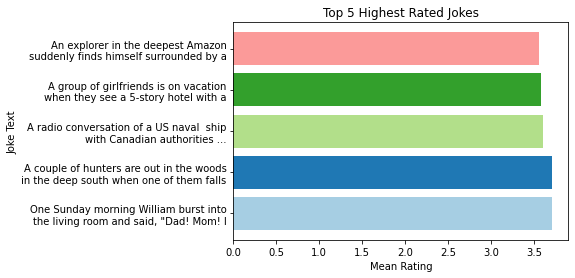

In [15]:

# Top Rated Jokes Plot
plt.figure(figsize=(10,10))

# Group the jokes by ID and compute the mean rating for each joke
joke_ratings = df.groupby(['jokeId', 'jokeText'])['rating'].mean()

# Sort the jokes by mean rating and select the top 10
top_jokes = joke_ratings.sort_values(ascending=False).head(5)

# Extract the joke texts and mean ratings for the top 10 jokes
joke_texts = top_jokes.index.get_level_values('jokeText').tolist()
mean_ratings = top_jokes.values.tolist()

# Wrap long text into two lines
joke_texts = [textwrap.fill(text, width=40).split('\n')[:2] for text in joke_texts]
joke_texts = ['\n'.join(text) for text in joke_texts]
joke_texts

# Plot the top rated jokes
fig, ax = plt.subplots()
ax.barh(joke_texts, mean_ratings, align='center',color=colors)
ax.set_xlabel('Mean Rating')
ax.set_ylabel('Joke Text')
ax.set_title('Top 5 Highest Rated Jokes')

plt.show()

<Figure size 720x720 with 0 Axes>

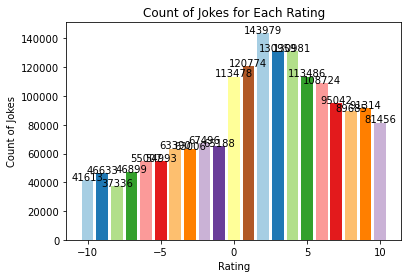

In [16]:
# Count of Jokes for Each Rating Plot
plt.figure(figsize=(10,10))

df['Round_Rating'] = round(df['rating'])

# Group the jokes by rating and count the number of jokes in each rating group
rating_counts = df.groupby('Round_Rating')['jokeId'].count()

# Plot the count of jokes for each rating
fig, ax = plt.subplots()
ax.bar(rating_counts.index, rating_counts.values,color=colors)
ax.set_xlabel('Rating')
ax.set_ylabel('Count of Jokes')
ax.set_title('Count of Jokes for Each Rating')

# Add the count of jokes on top of each bar
for i, v in enumerate(rating_counts.values):
    ax.text(i-10, v + 10, str(v), ha='center')

plt.show()

# 4. KNN


In this assignment, a RecSys has been built using the Jester Price dataset, which contains user ratings for jokes. 

The KNN model built in this assignment is based on the **user-user similarity**.

The implemented RecSys uses the KNN algorithm to find the most similar users to a given input user and recommends a joke based on ratings of the similar users.

The KNN algorithm works by comparing the ratings of the input user with those of other users in the dataset, and finding the k most similar users. The similarity between users is determined by the distance between their rating vectors. Once the k most similar users have been identified, the RecSys looks at the jokes rated by these users and recommends the joke with the highest average rating among them.

The system is built on the Jester  dataset, which includes joke IDs, user IDs,joke texts  and joke ratings. By leveraging this data, it is able to provide users with recommendations that are tailored to their preferences and rating history.


This implementation offers a straightforward and effective approach to recommend jokes to users based on the ratings of other users with similar taste. The RecSys has the potential to enhance user engagement and satisfaction by providing personalized recommendations. The algorithm can also be further improved by implementing different distance metrics, or by incorporating other features such as the text content of jokes, to provide even more accurate recommendations

In [17]:
df_filtered = df_filtered.sort_values(['userId','jokeId',])

In [18]:
# Creating User-Joke Matrix
jokes_user_matrix=df_filtered.pivot(index='userId', columns= 'jokeId',values='rating').fillna(0)

In [19]:
# Split the dataset into train and test sets

jokes_user_train, jokes_user_test = train_test_split(jokes_user_matrix, test_size=0.2, shuffle=False)

train_data=  df_filtered[df_filtered['userId'].isin(jokes_user_train.index.tolist())]
test_data= df_filtered[df_filtered['userId'].isin(jokes_user_test.index.tolist())]

In [20]:
# Preprocess the data into a sparse matrix format
csrtrain = csr_matrix(jokes_user_train.values)

##  4.1 Hyperparameter Tuning on  KNN Algorithm

The goal of hyperparameter tuning is to find the combination of hyperparameters that produces the best performance on the given dataset. The hyperparameters are values that are set before training the model and cannot be learned during training.  In this assignment hyperparameter tuning is done by searching through a range of possible hyperparameters and evaluating the performance of the model using each combination. The evaluation metric used to measure performance is selected as mean of the distances of nearest neighbors aka similar users. If this metric is low it means that the distances are small and neighbors are similar. If this metric is high then distances to  neighbors are higher and users are less similar. The hyperparameters that result in the best performance on the evaluation metric(minimum distance) are selected as the optimal hyperparameters for the model.

In [21]:
#Creating an empty dataframe to store the results of hyperparameter tuning for KNN algorithm
knn_tuning_results = pd.DataFrame(columns=['n_neighbors', 'algorithm', 'metric','mean_distances'])

#Defining the range of hyperparameters to be tuned
n_neighbors= [10, 20, 30]
algorithm= [ 'brute', 'auto']
metric=['cosine', 'euclidean']

#Loop over the combinations of hyperparameters to perform the KNN algorithm with each combination
for i in n_neighbors:
    for j in  algorithm:
        for k in  metric:
            # Create a KNN object with the current hyperparameter combination
            knn = NearestNeighbors(n_neighbors=i,
                           algorithm=j,
                           metric=k)
            # Fit the KNN model with the training data
            knn.fit( csrtrain)
            # Calculate the distances and indices of similar users
            distances, indices = knn.kneighbors(csrtrain, n_neighbors=i)
            # Print the mean of distances to similar users for the current hyperparameter combination
            print('For n=' , i, '  algorithm=', j, '  metric=' , k , '  Mean of distances to similar users= ' , distances.mean())

            # Append the hyperparameter combination and mean distance to the knn_tuning_results dataframe
            knn_tuning_result = {'n_neighbors': i, 'algorithm': j,'metric': k, 'mean_distances': distances.mean()}
            knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)

For n= 10   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.3621879565060701


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 10   algorithm= brute   metric= euclidean   Mean of distances to similar users=  34.56583181612742


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 10   algorithm= auto   metric= cosine   Mean of distances to similar users=  0.3621879565060701


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 10   algorithm= auto   metric= euclidean   Mean of distances to similar users=  34.56583181612742


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 20   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.39912152778212406


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 20   algorithm= brute   metric= euclidean   Mean of distances to similar users=  37.32624753630715


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 20   algorithm= auto   metric= cosine   Mean of distances to similar users=  0.39912152778212406


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 20   algorithm= auto   metric= euclidean   Mean of distances to similar users=  37.32624753630715


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 30   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.41658175522933316


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 30   algorithm= brute   metric= euclidean   Mean of distances to similar users=  38.503154477644536


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 30   algorithm= auto   metric= cosine   Mean of distances to similar users=  0.41658175522933316


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


For n= 30   algorithm= auto   metric= euclidean   Mean of distances to similar users=  38.503154477644536


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3591503917.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)


In the above, we can see the distances(errors) for each combination of hyperparameters for the KNN model. In the following code, the optimal hyperparameters are selected according to minimum of the distances.

In [24]:
knn_tuning_results

,n_neighbors,algorithm,metric,mean_distances
0,10,brute,cosine,0.362188
1,10,brute,euclidean,34.565832
2,10,auto,cosine,0.362188
3,10,auto,euclidean,34.565832
4,20,brute,cosine,0.399122
5,20,brute,euclidean,37.326248
6,20,auto,cosine,0.399122
7,20,auto,euclidean,37.326248
8,30,brute,cosine,0.416582
9,30,brute,euclidean,38.503154


In [26]:
knn_tuning_results['mean_distances'] = knn_tuning_results['mean_distances'].astype(float)

In [27]:
# Finding the index of the row with the minimum mean distance
index_min_value = knn_tuning_results['mean_distances'].idxmin()

In [29]:
# Finding the index of the row with the minimum mean distance
index_min_value = knn_tuning_results['mean_distances'].idxmin()

#Getting the optimal hyperparameters from the row with the minimum mean distance
best_n_neighbors = knn_tuning_results.iloc[index_min_value, 0]
best_algorithm = knn_tuning_results.iloc[index_min_value,1]
best_metric = knn_tuning_results.iloc[index_min_value, 2]

#Printing the optimal hyperparameters
print('Optimal hyperparameters for the KNN model are n=' , best_n_neighbors, '  algorithm=', best_algorithm, '  metric=' , best_metric )


Optimal hyperparameters for the KNN model are n= 10   algorithm= brute   metric= cosine



After performing hyperparameter tuning on a KNN algorithm, the optimal hyperparameters are determined based on their ability to minimize the error of the model. Since the optimal hyperparameters are determined now, they can be used to train the KNN model with the goal of minimizing the error.

##  4.2 Building RecSys based on KNN

In [30]:
# Create a new NearestNeighbors object with the best hyperparameters found during tuning
knn = NearestNeighbors(n_neighbors=best_n_neighbors,
                           algorithm=best_algorithm,
                           metric=best_metric)

# Fitting the KNN model on the training data
knn.fit(csrtrain)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [31]:
csrtrain.shape

(8232, 140)

#### - Creating a function that finds similar users to a given user

This function takes an input_user_index and neighbor_count as inputs. It calculates the k nearest neighbors of the input user based on their interaction history with jokes using the KNN model trained earlier. Then, it prints the most similar users to the input user based on the calculated distances. Finally, it creates a list of similar users based on their indices in the training data and returns it.

In [32]:
def get_similar_users(input_user_index, neighbor_count=best_n_neighbors+1):
    
    # Finding the k nearest neighbors of the input user 
    distances, indices = knn.kneighbors(jokes_user_train.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count)
  
    # indices ARE INDEX OF THE USER ID
    # jokes_user_train.index[indices.flatten()[1]] ARE THE USER ID OF THE INDEX
    # Creating a list of similar users 

    similaruser_ids=[]

    # Printing the most similar users to the input user based on the calculated distances
    for i in range(0,len(distances.flatten())):
        if i==0:            #Most similar user to input user is itself with zero distance. So not printing the input user 
            print('Similar Users for User',jokes_user_train.index[indices.flatten()[i]],' \n')
        else:
            print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )
            similaruser_ids.append(jokes_user_train.index[indices.flatten()[i]])



    return similaruser_ids
    

#### - Creating a function that takes a dataframe of jokes rated by similar users and returns the joke with the highest average rating

This function takes a pandas DataFrame object 'JokesfromSimilarUsers' as input, which contains a list of jokes and their average rating by similar users. 
The code first converts the 'jokeId', 'avg_rating_by_similar_users', and 'jokeText' columns of the DataFrame into lists using the 'tolist()' method. 
Then, it initializes variables to keep track of the maximum rating and the recommended joke. 
The code loops through the lists to find the joke with the highest rating. For each joke, the code checks whether its rating is greater than the current maximum rating (maxrating). If so, the joke's text (textlist[i]) is stored in the recommended_joke variable and its rating is stored in the maxrating variable. Finally, the function returns the recommended joke with the highest rating.

In [33]:
def get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers):

    # Converting jokeId, jokeText and avg_rating_by_similar_users columns to lists
    
    jokeidlist=JokesfromSimilarUsers["jokeId"].tolist()
    ratelist= JokesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    textlist= JokesfromSimilarUsers["jokeText"].tolist()

    # Initialize variables to keep track of maximum rating and recommended joke
    maxrating=0
    recommended_joke = None

    #Loop through the lists to find the joke with the highest rating
    for i in range(0,len(jokeidlist)):
        if (ratelist[i]> maxrating):
            recommended_joke=textlist[i]
            maxrating=ratelist[i]

    # Returning the recommended joke with the highest rating            
    return recommended_joke

#### - Creating a function that takes a dataframe of jokes rated by similar users and returns the joke with the highest average rating

This function get_KNN_recommandations_for_user takes an input user ID and neighbor count as inputs. It first finds the index of the input user in the train_data dataframe, and then gets the similar users using the get_similar_users function created earlier.

Then, it filters out the data for the similar users and calculates the average rating for each joke by these users. It creates a new dataframe JokesfromSimilarUsers which contains unique jokes with their corresponding joke ID, joke text, and average rating by similar users.

Next, it removes the jokes that the input user has already rated from the JokesfromSimilarUsers dataframe.

If all the jokes rated by similar users are also watched by the input user, then the function recursively calls itself with an increased neighbor user count to find more dissimilar users to generate recommendations.


After this, it calls the function get_Jokes_with_Highhest_Rating_from_Similar_Users to get the joke with the highest average rating by similar users from the filtered JokesfromSimilarUsers dataframe.

Then, it finds the rating of this joke by similar users and its general rating in the entire dataset, and prints these along with the recommended joke for the input user.





In [34]:
def get_KNN_recommandations_for_user(input_user, neighbor_count=best_n_neighbors+1):
   
    #Getting the index of given input user in train data
    user_ids = train_data['userId'].unique()
    user_ids.sort()
    user_ids=user_ids.tolist()
    input_user_index = user_ids.index(input_user)
   
    
    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users(input_user_index,neighbor_count)
    
    #Filtering the data to only include the rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["userId"].isin(similaruser)]

    #Computing the Average Rating of Jokes among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


    # Getting jokes rated by similar users and   excluding jokes that already rated by input_user
    JokesfromSimilarUsers=None
    JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])
    JokesRatedBySelectedUser=train_data[(train_data['userId'] == input_user)]['jokeText'].tolist()
    JokesfromSimilarUsers = JokesfromSimilarUsers[~JokesfromSimilarUsers['jokeText'].isin(JokesRatedBySelectedUser)]

    # If all the jokes  rated by  similar users are also  rated by the selected user, call the function again with increased  neighbor user count
    if (JokesfromSimilarUsers.empty):
        print('All the jokes rated  by', (neighbor_count-1),' similar users are all  rated by the selected user. Similar user count  is increased by 5 to ', neighbor_count+5)
        return get_KNN_recommandations_for_user(input_user, neighbor_count+5)


    # Getting the recommended joke with the highest average rating among similar user
    recommended_joke=None
    recommended_joke = get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers)


    # Assigning rating values to the  variables that desired to print
        # get average rating for recommended joke among similar users
    RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke)]['avg_rating_by_similar_users'].iloc[0]
        # get general rating for recommended joke in training data
    GeneralRating=round(train_data[(train_data['jokeText'] == recommended_joke)].groupby('jokeId')['rating'].transform('mean').iloc[0])
    
    # Printing the recommendation joke with ratings
    print('\n \n For User ',input_user, 'recommended joke is: \n', recommended_joke,' \n', ' with Rating by Similar Users: ' , RatingbySimilarUsers,' \n', ' with General Rating: ' , GeneralRating )
 
     

#### - Getting Joke Recommandation to Random User based on KNN


This code selects a random user id from the list of unique user ids in the train_data dataframe using the np.random.choice() function. The get_KNN_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a joke recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the index of the input user id in the user_ids list using the index() method. Then, it calls the get_similar_users() function to find a list of similar users to the input user based on their rating patterns. The function then filters out the jokes already rated by the input user and calculates the average rating of the remaining jokes by the similar users. It selects the joke with the highest rating and returns its text as the recommended joke for the input user.

Finally, the function also prints the rating of the recommended joke by the similar users and the general rating of the same joke in the entire dataset. This code allows for easy testing of the recommendation algorithm on different users.

In [35]:
# Getting the  list of unique user IDs in training data
user_ids = train_data['userId'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Joke Recommandation based on KNN to a Random User from the list of User IDs 
get_KNN_recommandations_for_user(np.random.choice(user_ids))  #Input user id can be changed to any user id available in the dataset

Similar Users for User 38830  

Most Similar User 1 : User_Id 33489  with distance of  0.3112653467609411
Most Similar User 2 : User_Id 40608  with distance of  0.3682205787628192
Most Similar User 3 : User_Id 33869  with distance of  0.3892624325108006
Most Similar User 4 : User_Id 37611  with distance of  0.38990171750167435
Most Similar User 5 : User_Id 22240  with distance of  0.39371444479174234
Most Similar User 6 : User_Id 41709  with distance of  0.40300590935821234
Most Similar User 7 : User_Id 14573  with distance of  0.4031589767307432
Most Similar User 8 : User_Id 49621  with distance of  0.40539945329571436
Most Similar User 9 : User_Id 1584  with distance of  0.40924949954285794
Most Similar User 10 : User_Id 33452  with distance of  0.40971315104147477
All the jokes rated  by 10  similar users are all  rated by the selected user. Similar user count  is increased by 5 to  16
Similar Users for User 38830  

Most Similar User 1 : User_Id 33489  with distance of  0.311265346

/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2482876684.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2482876684.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
/var/folders/y7/_v7_fsx5

Similar Users for User 38830  

Most Similar User 1 : User_Id 33489  with distance of  0.3112653467609411
Most Similar User 2 : User_Id 40608  with distance of  0.3682205787628192
Most Similar User 3 : User_Id 33869  with distance of  0.3892624325108006
Most Similar User 4 : User_Id 37611  with distance of  0.38990171750167435
Most Similar User 5 : User_Id 22240  with distance of  0.39371444479174234
Most Similar User 6 : User_Id 41709  with distance of  0.40300590935821234
Most Similar User 7 : User_Id 14573  with distance of  0.4031589767307432
Most Similar User 8 : User_Id 49621  with distance of  0.40539945329571436
Most Similar User 9 : User_Id 1584  with distance of  0.40924949954285794
Most Similar User 10 : User_Id 33452  with distance of  0.40971315104147477
Most Similar User 11 : User_Id 33729  with distance of  0.4144614446186403
Most Similar User 12 : User_Id 37937  with distance of  0.4185329263632104
Most Similar User 13 : User_Id 35488  with distance of  0.41886802728245

/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2482876684.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2482876684.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


#### - Showing each step

In [36]:
# Getting the  list of unique user IDs in training data
user_ids = train_data['userId'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Joke Recommandation based on KNN to a Random User from the list of User IDs 
#get_KNN_recommandations_for_user(35560)
input_user_index = user_ids.index(35560)
print('\n Input users index is ', input_user_index)
neighbor_count=10
# Finding the k nearest neighbors of the input user 
distances, indices = knn.kneighbors(jokes_user_train.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count+1)
print(' \n distances are ')
print(distances.flatten())

print(' \n indices are')
print(indices.flatten())

similaruser_ids=[]
    # Printing the most similar users to the input user based on the calculated distances
for i in range(0,len(distances.flatten())):
    if i==0:            #Most similar user to input user is itself with zero distance. So not printing the input user 
        print(' \n Similar Users for User',jokes_user_train.index[indices.flatten()[i]],' \n')
    else:
        print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )
        similaruser_ids.append(jokes_user_train.index[indices.flatten()[i]])

print(' \n similaruserid list ')

print(similaruser_ids)




 #Filtering the data to only include the rows of similar users
similar_user_data=None
similar_user_data = train_data[train_data["userId"].isin(similaruser_ids)]
#Computing the Average Rating of Jokes among the similar users 
similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
print(' \n similar_user_data ')
print(similar_user_data)

# Getting jokes rated by similar users and   excluding jokes that already rated by input_user
JokesfromSimilarUsers=None
JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])
print(' \n JokesfromSimilarUsers ')
print(JokesfromSimilarUsers)
JokesRatedBySelectedUser=train_data[(train_data['userId'] == 35560)]['jokeText'].tolist()
print(' \n JokesRatedBySelectedUser ')
print(JokesRatedBySelectedUser)
JokesfromSimilarUsers = JokesfromSimilarUsers[~JokesfromSimilarUsers['jokeText'].isin(JokesRatedBySelectedUser)]
print(' \n JokesfromSimilarUsers ecluding movies of user ')
print(JokesfromSimilarUsers)

# Getting the recommended joke with the highest average rating among similar user
recommended_joke=None
recommended_joke = get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers)
RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke)]['avg_rating_by_similar_users'].iloc[0]

print(' \n recommended_joke ')
print(recommended_joke, ' with Rating by Similar Users: ' , RatingbySimilarUsers)

    


 Input users index is  5059
 
 distances are 
[3.33066907e-16 3.95359561e-01 4.34080177e-01 4.37761506e-01
 4.73041320e-01 4.76263873e-01 4.79189974e-01 4.80054261e-01
 4.86133902e-01 4.86884173e-01 4.89175830e-01]
 
 indices are
[5059 2418 3732 2404 8043 6381 4110 2504 6439 7770 6621]
 
 Similar Users for User 35560  

Most Similar User 1 : User_Id 16481  with distance of  0.39535956062392763
Most Similar User 2 : User_Id 29387  with distance of  0.43408017655388254
Most Similar User 3 : User_Id 16335  with distance of  0.4377615061779373
Most Similar User 4 : User_Id 48727  with distance of  0.4730413198706176
Most Similar User 5 : User_Id 41091  with distance of  0.47626387279734816
Most Similar User 6 : User_Id 31271  with distance of  0.47918997439820976
Most Similar User 7 : User_Id 17166  with distance of  0.48005426069764656
Most Similar User 8 : User_Id 41332  with distance of  0.4861339017089066
Most Similar User 9 : User_Id 47490  with distance of  0.4868841725748124
Most S

/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3343270999.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


##  4.2 Evaluation of KNN Model 

To evaluate the performance of the KNN model and to measure its effectiveness in generating accurate recommendations, a comparison will be made between the predicted ratings and the actual ratings for a predefined set of users and jokes.

 The objective is to identify the users for whom the model recommends a joke that they have already rated. Predicted ratings will be the average ranking of jokes among the similar users. This  allows  to calculate the Root Mean Squared Error (RMSE) between the user's actual rating and the predicted rating for the recommended joke.

By calculating the RMSE, it is possible to determine how closely the predicted ratings match the actual ratings. A lower RMSE indicates better accuracy and suggests that the model is doing a good job of recommending jokes that the user would rate highly. This information can be used to fine-tune the model to further improve its accuracy and to provide better recommendations to users. 

In [37]:
# Preprocess the data into a sparse matrix format
csrtest = csr_matrix(jokes_user_test.values)

In [38]:
jokes_user_test

jokeId,5,7,8,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49941,0.0,-8.125,-7.844,-8.062,-8.281,7.406,-4.344,-5.594,5.625,0.0,-3.250,-7.031,-5.812,-2.906,-6.719,0.031,0.0,6.250,-1.938,-2.375,0.0,5.812,-2.688,6.875,9.812,7.938,-8.281,4.719,-2.812,4.719,-6.688,-2.344,0.0,-2.156,6.750,4.531,-2.969,-2.719,2.719,-2.312,0.0,0.0,7.125,-3.906,-7.875,6.781,-3.062,4.938,2.469,-3.625,0.0,2.812,0.094,-3.625,-4.188,7.594,-8.062,-1.031,2.062,5.406,-6.094,8.344,0.0,-1.812,5.500,1.031,3.156,-1.156,-6.625,0.0,4.312,2.938,7.000,-2.688,-6.500,-4.031,3.250,-2.469,0.406,1.344,-5.531,5.656,6.094,-1.781,-2.875,7.719,-3.375,3.406,-6.625,0.0,-6.438,0.062,5.469,3.781,6.625,6.344,-3.094,2.375,7.938,-2.688,4.938,-2.438,1.656,5.312,6.406,0.0,6.781,4.875,6.188,4.500,8.406,-2.062,-6.844,-5.969,-1.812,5.250,6.688,0.281,8.438,8.969,0.156,-5.781,-0.344,8.500,2.469,-1.656,-2.062,0.594,-4.812,-6.938,-6.469,-0.594,5.938,8.125,5.125,-2.969,-3.688,0.969,-2.562,4.188
49946,0.0,-9.875,-9.781,-9.812,-9.812,-9.875,-9.875,-9.781,-9.781,0.0,0.000,0.000,-9.781,0.000,-9.562,0.000,0.0,9.906,9.531,0.000,0.0,-9.781,0.000,-6.625,9.156,-9.000,2.844,0.000,6.812,0.000,0.000,9.344,0.0,0.000,-9.562,-9.656,8.656,4.531,8.906,0.000,0.0,0.0,9.312,-9.750,-4.750,9.406,0.000,0.000,0.000,0.000,0.0,10.000,9.844,0.000,0.000,5.719,-5.625,9.594,-0.844,6.188,0.000,9.875,0.0,0.000,-9.562,1.812,0.000,-9.594,0.000,0.0,0.000,0.000,0.000,0.000,0.000,6.375,0.000,0.000,9.656,0.000,2.719,9.375,4.312,3.438,5.750,0.000,-2.750,0.000,0.000,0.0,0.000,-9.625,-9.656,9.500,9.938,9.875,0.000,7.969,7.906,9.750,9.938,9.969,9.781,9.875,9.844,0.0,9.750,9.719,9.844,9.500,9.562,9.250,0.000,0.000,0.000,8.719,9.688,9.312,9.906,8.125,-5.062,0.000,7.531,-0.688,-9.531,4.719,0.000,6.812,8.156,-9.344,0.000,0.000,6.156,9.844,-9.688,0.000,9.719,8.969,-9.688,9.688
49961,0.0,-6.125,5.781,4.125,-0.656,2.219,-2.281,2.375,3.938,0.0,3.156,0.000,-9.594,0.000,0.000,2.188,0.0,0.000,1.844,0.000,0.0,4.844,0.000,0.000,4.812,1.000,0.000,-5.312,-6.812,-9.844,0.000,0.000,0.0,0.000,-9.469,0.000,2.406,4.000,1.531,6.594,0.0,0.0,3.125,5.031,0.000,3.719,0.000,0.000,0.000,0.000,0.0,4.719,1.156,0.000,-9.594,4.375,0.000,0.688,-0.188,0.000,0.000,3.562,0.0,0.000,0.000,2.781,0.000,-7.062,0.000,0.0,2.781,0.000,0.000,1.906,0.000,2.531,3.562,-5.781,5.969,-4.438,0.000,-2.219,4.938,5.062,0.000,5.375,2.406,0.000,3.250,0.0,0.000,0.000,-7.062,7.031,3.750,4.938,-5.406,5.844,-2.906,5.219,5.625,-2.281,0.000,-1.625,-5.094,0.0,3.625,3.438,-8.219,0.000,-9.375,-9.625,0.000,0.000,4.906,-5.438,2.125,-7.781,2.031,0.000,0.000,-6.188,0.031,5.656,-9.906,0.000,-7.844,2.406,0.000,-2.750,0.000,0.000,2.688,2.188,0.000,0.000,4.281,2.125,-3.562,-0.375
49963,0.0,6.531,0.188,4.688,1.719,5.688,4.438,4.812,3.125,0.0,0.312,9.781,4.125,0.219,6.500,7.250,0.0,9.781,1.719,1.312,0.0,0.469,1.312,2.250,8.531,6.094,9.719,9.812,7.875,2.094,6.719,-0.125,0.0,-0.625,1.031,2.281,-0.062,-0.125,9.750,5.438,0.0,0.0,9.812,2.156,9.812,-6.719,-1.469,5.469,0.031,9.781,0.0,-3.562,3.688,-1.156,-9.500,-1.000,9.781,5.875,9.156,7.312,9.812,7.188,0.0,0.562,6.344,9.750,8.562,6.656,0.250,0.0,9.750,1.250,1.656,7.406,0.125,0.594,0.375,6.969,9.688,5.406,1.406,9.781,5.469,4.781,0.188,0.375,8.562,0.156,9.812,0.0,7.500,7.594,9.781,0.906,5.594,3.844,0.438,7.344,7.500,0.094,1.688,7.156,9.781,9.625,7.406,0.0,7.250,0.844,2.688,9.719,9.719,7.406,4.531,2.750,5.406,0.625,-1.812,1.188,1.375,-0.375,7.906,8.562,9.750,8.562,6.188,8.531,1.094,9.781,4.938,-7.062,-4.844,4.312,

#### - Creating a function that finds similar users to a given Test user

This function takes an input_test_user and neighbor_count as inputs. It first creates a row of the test user's interaction history with jokes and then finds the k nearest neighbors of the test user based on their interaction history with jokes using the KNN model trained earlier. It then prints the most similar users to the test user based on the calculated distances. Finally, it creates a list of similar user ids in the training data and returns it.

In [39]:
def get_similar_users_for_testing(input_test_user, neighbor_count=best_n_neighbors+1):

    test_user_row = jokes_user_test.loc[input_test_user].values.reshape(1, -1)
    distances_test, indices_test = knn.kneighbors(test_user_row, n_neighbors=neighbor_count)


    similaruser2=[]


    # print('\n Similar Users for User', input_test_user,' \n')
  
    # Printing the most similar users to the input user based on the calculated distances
    for i in range(1,len(distances_test.flatten())):
    
        #print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices_test.flatten()[i]]),' with distance of ',str(distances_test.flatten()[i]) )
        #Creating list for the similar users
        similaruser2.append(jokes_user_train.index[indices_test.flatten()[i]])

    
    return similaruser2
    

#### - Creating a function that gets the highest rated

This function is the same with training part

In [40]:
def get_Jokes_with_Highhest_Rating_from_Similar_Users_for_testing(JokesfromSimilarUsers):

    # Converting jokeId, jokeText and avg_rating_by_similar_users columns to lists
    
    jokeidlist=JokesfromSimilarUsers["jokeId"].tolist()
    ratelist= JokesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    textlist= JokesfromSimilarUsers["jokeText"].tolist()

    # Initialize variables to keep track of maximum rating and recommended joke
    maxrating=0
    recommended_joke2 = None

    #Loop through the lists to find the joke with the highest rating
    for i in range(0,len(jokeidlist)):
        if (ratelist[i]> maxrating):
            recommended_joke2=textlist[i]
            maxrating=ratelist[i]

    # Returning the recommended joke with the highest rating            
    return recommended_joke2

#### - Creating a function that gets joke recommandation

In [41]:
def get_KNN_recommandations_for_user_for_testing(input_test_user, neighbor_count=best_n_neighbors+1):
   

    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users_for_testing(input_test_user,neighbor_count)

    #Filtering the data to only include the rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["userId"].isin(similaruser)]

    #Computing the Average Rating of Jokes among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


    # Getting jokes rated by similar users
    JokesfromSimilarUsers=None
    JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])


    # Getting the recommended joke with the highest average rating among similar user
    recommended_joke2=None
    recommended_joke2 = get_Jokes_with_Highhest_Rating_from_Similar_Users_for_testing(JokesfromSimilarUsers)


    # Assigning rating values to the  variables that desired to print
        # get average rating for recommended joke among similar users
    RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke2)]['avg_rating_by_similar_users'].iloc[0]

    return recommended_joke2,RatingbySimilarUsers  

     

In [ ]:
((test_data['userId'] == 49963) & (test_data['jokeText'] == a)).any()

True

In [ ]:
test_data[(test_data['userId'] == 49963)& (test_data['jokeText'] == a) ]

,userId,jokeId,rating,jokeText
1403360,49963,84,7.406,Q: What is the difference between Mechanical E...


In [ ]:
test_data[(test_data['userId'] == 49963) &(test_data['jokeText'] == a)]['rating'].iloc[0]

7.406000000000001

In [ ]:
test_row = {'userid': 49985, 'joketext': a,'predicted_rating': RatingbySimilarUsers, 'actual_rating': test_data[(test_data['userId'] == 49985) &(test_data['jokeText'] == a)]['rating'].iloc[0]}
print('\n test_row', test_row,' \n ' )


 test_row {'userid': 49985, 'joketext': 'Q: What is the difference between Mechanical Engineers and Civil \nEngineers?\n \nA: Mechanical Engineers build weapons, Civil Engineers build targets.\n', 'predicted_rating': 8.722, 'actual_rating': 1.5}  
 


# APPLYING TEST


In [51]:
#APPLYING TESTS
test_matrix = pd.DataFrame(columns=['userid', 'joketext', 'predicted_rating','actual_rating'])

#Getting Joke Recommandation to Every User in Test Data based on KNN

user_ids_test = test_data['userId'].unique()
user_ids_test.sort()
user_ids_test=user_ids_test.tolist()

for test_user_id in user_ids_test[-20:]:

    test_user_row = jokes_user_test.loc[test_user_id].values.reshape(1, -1)
    recommended_joke=None
    RatingbySimilarUsers  =None
    
    recommended_joke, RatingbySimilarUsers  = get_KNN_recommandations_for_user_for_testing(test_user_id)


    # Check if the actual rating for the recommended joke is non-zero
    if ((test_data['userId'] == test_user_id) & (test_data['jokeText'] == recommended_joke)).any() and  test_data[(test_data['userId'] == test_user_id) & (test_data['jokeText'] == recommended_joke)]['rating'].values[0] != 0:
        test_row = {'userid': test_user_id, 'joketext': recommended_joke,'predicted_rating': RatingbySimilarUsers, 'actual_rating': test_data[(test_data['userId'] == test_user_id) &(test_data['jokeText'] == recommended_joke)]['rating'].iloc[0]}
        test_matrix = test_matrix.append(test_row, ignore_index=True)
       # print('recommended movie is  ON THE LIST for user', test_user_id )

    #else:
       # print('recommended movie is not on the list for user', test_user_id)
        

# calculate the RMSE between the predicted ratings and actual ratings

y_test = test_matrix['actual_rating']
y_pred =test_matrix['predicted_rating']
print(test_matrix.head())
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\n % ", ((test_matrix.shape[0]/len(user_ids_test))*100), ' of the test users are recommended a joke that they are already rated')
print("\n When comparing the predicted ratings and actual rating for those users, RMSE is calculated:  ", ((test_matrix.shape[0]/len(user_ids_test))*100), ' of the test users are recommended a joke that they are already rated')

print("\n RMSE:", rmse)
 

/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3793230404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2537026947.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_matrix = test_matrix.append(test_row, ignore_index=True)
/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/3793230404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

  userid                                           joketext predicted_rating  \
0  63829  A group of girlfriends is on vacation when the...           4.2876   
1  63839  Two attorneys went into a diner and ordered tw...            8.323   
2  63859  A teacher is explaining to her class how diffe...         7.222333   
3  63877  An old Scotsmen is sitting with a younger Scot...           6.4969   
4  63882  A drunk staggers into a Catholic Church, enter...             8.35   

  actual_rating  
0         9.781  
1         6.438  
2         1.844  
3         4.438  
4         9.562  

 %  0.7285089849441476  of the test users are recommended a joke that they are already rated

 When comparing the predicted ratings and actual rating for those users, RMSE is calculated:   0.7285089849441476  of the test users are recommended a joke that they are already rated

 RMSE: 3.962298020141307


/var/folders/y7/_v7_fsx55jngwk83d1p07t8r0000gn/T/ipykernel_1462/2537026947.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_matrix = test_matrix.append(test_row, ignore_index=True)


#### - Getting Joke Recommandation to Random User based on KNN


In [ ]:
# Getting the  list of unique user IDs in training data
test_users = np.unique(test_data['userId'].values)
test_users_sorted = sorted(test_users)
# test_users_list = test_users_sorted.tolist()

#Getting the Joke Recommandation based on KNN to a Random User from the list of User IDs 
randominput =np.random.choice(test_users_sorted)
print('\n random input is ',randominput)
get_KNN_recommandations_for_user_for_testing(randominput)  #Input user id can be changed to any user id available in the dataset


 random input is  60856

dilay1
 
 distances are 
[0.15394149 0.15583797 0.17302237 0.17425702 0.18203175 0.19784699
 0.205083   0.20730012 0.20832733 0.20908516 0.21120828]
0.15583797228097918
 
 indices are
[7938 6846 5948 6096 5822 6571 7223 6902 5729 2973 7850]
6846

 Similar Users for User 60856  

Most Similar User 1 : User_Id 43237  with distance of  0.15583797228097918
Most Similar User 2 : User_Id 39141  with distance of  0.17302237342072024
Most Similar User 3 : User_Id 39806  with distance of  0.17425701644257863
Most Similar User 4 : User_Id 38587  with distance of  0.18203174872121075
Most Similar User 5 : User_Id 41963  with distance of  0.1978469932594512
Most Similar User 6 : User_Id 45283  with distance of  0.20508300454736184
Most Similar User 7 : User_Id 43498  with distance of  0.20730012262009745
Most Similar User 8 : User_Id 38207  with distance of  0.20832733191393893
Most Similar User 9 : User_Id 19529  with distance of  0.20908516338663108
Most Similar User 10

c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


('An engineer, a physicist and a mathematician are sleeping in a\nroom. There is a fire in the room. The engineer wakes up, sees the fire,\npicks up the bucket of water and douses the fire and goes back to\nsleep. \n\nAgain there is fire in the room. This time, the physicist wakes\nup, notices the bucket, fills it with water, calculates the optimal\ntrajectory and douses the fire in minimum amount of water and goes\nback to sleep. \n\nAgain there is fire. This time the mathematician wakes up. \nHe looks at the fire, looks at the bucket and the water and\nexclaims, "A solution exists" and goes back to sleep.\n',
 8.06275)

# APPLYING TO ONE TEST USER EXAMPLE

In [ ]:
# APPLYING TO ONE TEST USER EXAMPLE
input_test_user_id= 49946
test_user_row = jokes_user_test.loc[49941].values.reshape(1, -1)
distancestest, indicestest = knn.kneighbors(test_user_row, n_neighbors=best_n_neighbors+1)


print(' \n distances are ')
print(distancestest.flatten())
print(distancestest.flatten()[1])

print(' \n indices are')

print(indicestest.flatten())
print(indicestest.flatten()[1])



print('\n Similar Users for User', input_test_user_id,' \n')
  
 # Printing the most similar users to the input user based on the calculated distances
for i in range(1,len(distancestest.flatten())):
    
    print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indicestest.flatten()[i]]),' with distance of ',str(distancestest.flatten()[i]) )



    #Creating list for the similar users
    similaruser2=[]
    for i in range(0,len(distances.flatten())):
        similaruser2.append(jokes_user_train.index[indicestest.flatten()[i]])
        
print(test_user_row)
jokes_user_train.loc[33640].values.reshape(1, -1)

from scipy.spatial.distance import cosine
a=jokes_user_test.loc[49941].values.reshape(1, -1)
cosine(a, jokes_user_train.loc[33640].values.reshape(1, -1))

 
 distances are 
[0.48984949 0.49014196 0.49249364 0.49484695 0.50894253 0.50958816
 0.51459717 0.51883234 0.51938623 0.52061704 0.52124159]
0.4901419609108971
 
 indices are
[1387 4635 8039 6144 5730 7061  571 1216 6433 1084 2243]
4635

 Similar Users for User 49946  

Most Similar User 1 : User_Id 33640  with distance of  0.4901419609108971
Most Similar User 2 : User_Id 48696  with distance of  0.49249363706927063
Most Similar User 3 : User_Id 40046  with distance of  0.49484694629071024
Most Similar User 4 : User_Id 38208  with distance of  0.5089425296883762
Most Similar User 5 : User_Id 44282  with distance of  0.5095881619757505
Most Similar User 6 : User_Id 2219  with distance of  0.5145971735815109
Most Similar User 7 : User_Id 6036  with distance of  0.5188323406028851
Most Similar User 8 : User_Id 41316  with distance of  0.5193862275891342
Most Similar User 9 : User_Id 5133  with distance of  0.5206170409235986
Most Similar User 10 : User_Id 15016  with distance of  0.52124

0.490141960910897

# 5. SVD

SVD is a widely used matrix factorization technique in machine learning that can be used for various tasks, including image compression, data compression, and recommender systems. It decomposes a matrix into three separate matrices, each representing the latent factors of the original matrix. 

In this assignment, a RecSys has been built using the Jester Price dataset, which contains user ratings for jokes. The implemented RecSys uses the SVD algorithm to identify similar jokes based on a user's highest rated joke and recommend them to the user.

The SVD algorithm works by decomposing the user-joke matrix into three separate matrices, each representing the latent factors of the original matrix. This factorization allows us to identify similar jokes based on the users' ratings, rather than just their content. To begin, the recommendation system takes the user ID as input and identifies the highest rated joke by that user. The SVD model is then applied to identify similar jokes to the user's highest rated joke, and these similar jokes are recommended to the user.

This implementation offers a powerful and accurate approach to recommend jokes to users based on their preferences, as identified by the SVD algorithm. The RecSys has the potential to enhance user engagement and satisfaction by providing personalized recommendations that match their sense of humor. The algorithm can also be further improved by incorporating other features such as the text content of jokes, to provide even more accurate recommendations.

##  5.1 Building RecSys based on SVD

### - Creating a function for calculating cosine similarity


Cosine similarity is a measure of similarity between two non-zero vectors that measures the cosine of the angle between them. It ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating no similarity.  Jokes can be represented as feature vectors, where each feature represents a characteristic of the joke. By comparing the feature vectors of different jokes, we can identify jokes that are similar to each other and recommend them to users who enjoy similar types of humor.

In [ ]:
# Creating a function for calculating cosine similarity

def cosine_similarity(v,u):
    # Calculate the dot product of v and u, and divide by the product of their magnitudes
    return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))  #The @ symbol is used to calculate the dot product of v and u 

### - Singular value decomposition


In [ ]:
# Singular value decomposition
u, s, vt = svd(matrix, full_matrices=False)

NameError: name 'matrix' is not defined

### - Creating a function for calculating cosine similarity


In [ ]:
def get_similar_jokes(userId, joke_index, num_jokes=10):
    # Calculate the cosine similarity between the given joke and all other jokes in the user-item matrix
    similarities = [cosine_similarity(vt[joke_index], vt[i]) for i in range(vt.shape[0])]

    # Getting the list of the jokes rated (aka heard) by the user  
    user_ratedjokes = train_data[(train_data['userId'] == userId)]['jokeId'].tolist()

  # Get the indices of the top similar jokes, excluding jokes already rated by the user
    similar_jokes_ids = []
    for i in np.argsort(similarities)[::-1]:
        joke_ids = i+1  #Since  (jokes_user_train.columns)[0]=joke id 1
        if  joke_ids not in user_ratedjokes: # excluding jokes already rated by the user
            similar_jokes_ids.append(joke_ids)
        if len(similar_jokes_ids) == num_jokes:
            break 
    return similar_jokes_ids

#### - Creating a function that recommends a joke for the User

This function get_SVD_recommandations_for_user takes an input user ID and joke count as inputs. The default value for recommended joke count is set to 1.

It first finds the highest rated joke by the given user. To do this, it sorts the user ratings in descending order and retrieves the joke ID   and title of the highest rated joke  from the first row.

Then, the function calls the get_similar_jokes() function with the user ID and highest rated joke ID as input parameters to find similar jokes. 

The function then prints the top (num_jokes) number of similar jokes for the user to the console using a for loop.


In [ ]:
def get_SVD_recommandations_for_user(userId, num_jokes=1):

    # Find the highest rated joke by the given user
        # Get all ratings made by the given user
    user_ratings = train_data[train_data['userId'] == userId]
        # Sort the ratings in descending order to find the highest rated joke
    user_ratings_sorted = user_ratings.sort_values(['rating'], ascending=[False])
        # Get the joke ID of the highest rated joke by the user
    highest_rated_joke_id = user_ratings_sorted.iloc[0]['jokeId']
        # Get the title of the highest rated joke
    highest_rated_joke_title = train_data[train_data['jokeId'] == highest_rated_joke_id]['jokeText'].values[0]
        # Print the title of the highest rated joke by the user
    print("Highest rated  joke by user", userId, "is:", highest_rated_joke_title)
    
    # Get similar jokes based on the highest rated joke
    similar_jokes=None
    similar_jokes= get_similar_jokes(userId,highest_rated_joke_id)

    
    # Print the top 'num_jokes' number of similar jokes for the user
    print("Top", num_jokes, "similar jokes for user ", userId , ': ')
    for i, jokeId in enumerate(similar_jokes):
        print(i+1, ".", similar_jokes[i], ' ',  train_data[train_data['jokeId'] == similar_jokes[i]]['jokeText'].values[0])

#### - Getting Joke Recommandation to Random User based on SVD


This code selects a random user id from the list of unique user ids. The get_SVD_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a joke recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the highest rated joke by a given user, and then finds similar jokes based on that highest rated joke. It then prints the highest rated joke and the top recommended jokes to the console.

This code allows for easy testing of the recommendation algorithm on different users.

In [ ]:

#Getting the Joke Recommandation based on SVD to a Random User from the list of User IDs 

get_SVD_recommandations_for_user (np.random.choice(user_ids))  #Input user id can be changed to any user id available in the dataset


##  5.2 Evaulation of SVD Model 

In [ ]:
def get_similar_jokes2(joke_index, num_jokes=10):
    
    
    # Calculate the cosine similarity between the given joke and all other joke in the user-item matrix
    similarities = [cosine_similarity(vt[joke_index], vt[i]) for i in range(vt.shape[0])]
    
    # Get the indices of the top similar jokes
    similar_joke_indices = np.argsort(similarities)[::-1][1:num_jokes+1]
    
    # Get the ids of the top similar jokes
    similar_jokes_ids = [list(jokes_user_train.columns)[i] for i in similar_joke_indices]
    
    return similar_jokes_ids

In [ ]:
def get_SVD_recommandations_for_user2(userId, num_jokes=10):

    # Find the highest rated joke by the given user
    user_ratings = train_data[train_data['userId'] == userId]
    user_ratings_sorted = user_ratings.sort_values(['rating'], ascending=[False])
    highest_rated_joke_id = user_ratings_sorted.iloc[0]['jokeId']
    highest_rated_joke_title = train_data[train_data['jokeId'] == highest_rated_joke_id]['jokeText'].values[0]
    print("Highest rated  joke by user", userId, "is:", highest_rated_joke_title)
    
    # Find the similar jokes to the   highest rated joke by the given user
    similar_jokes= get_similar_jokes2(highest_rated_joke_id)

    # Print the top similar jokes
    print("Top", num_jokes, "similar jokes for user ", userId , ': ')
    for i, jokeId in enumerate(similar_jokes):
        print(i+1, ".", similar_jokes[i], ' ',  train_data[train_data['jokeId'] == similar_jokes[i]]['jokeText'].values[0])

#  6. Answering Business Questions 


In [ ]:
row_index = spars_train.nonzero()[0][user_index]